In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F

Using TensorFlow backend.


In [3]:
from model_utils import *

from perprocess_utils import *

from train_utils import *

from sklearn.model_selection import train_test_split

import pickle

In [4]:
%matplotlib notebook

import matplotlib.pyplot as plt

In [5]:
CRAWL_EMBEDDING_PATH = '/home/ravi/embeds/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '/home/ravi/embeds/glove.840B.300d.txt'
NUM_MODELS = 1

#train = pd.read_csv('../../../data/train.csv')
#test = pd.read_csv('../../../data/test.csv')

In [6]:
#emb_crawl = load_embeddings(CRAWL_EMBEDDING_PATH)

In [7]:
#emb_glv = load_embeddings(GLOVE_EMBEDDING_PATH)

In [8]:
#len(emb_crawl),len(emb_glv)

In [9]:
def check_embs(tok):
    return tok in emb_crawl, tok in emb_glv

In [11]:
#train = train.sample(frac=1,random_state=42)

In [12]:
#train = train.reset_index(drop=True)

In [13]:
#x_train = preprocess(train['comment_text'])
#x_train[:2]

In [14]:
#y_train = np.where(train['target'] >= 0.5, 1, 0)
#y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
#x_test = preprocess(test['comment_text'])

In [15]:
max_features = None

In [16]:
tokenizer = text.Tokenizer()
#tokenizer.fit_on_texts(list(x_train) + list(x_test))

In [17]:
#with open('tokenizer_with_punct.pkl','wb') as fl:
#    pickle.dump(tokenizer,fl)
with open('tokenizer_with_punct.pkl','rb') as fl:
    tokenizer = pickle.load(fl)
    
#with open('tokenizer.pkl','wb') as fl:
#    pickle.dump(tokenizer,fl)
#with open('tokenizer.pkl','rb') as fl:
#    tokenizer = pickle.load(fl)

In [18]:
#x_train = tokenizer.texts_to_sequences(x_train)
#x_test = tokenizer.texts_to_sequences(x_test)

In [19]:
#x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
#x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

In [22]:
#with open("x_train_with_punct.pkl",'wb') as fl:
#    pickle.dump(x_train,fl)
with open('x_train_with_punct.pkl','rb') as fl:
    x_train = pickle.load(fl)
#with open('x_test_with_punct.pkl','wb') as fl:
#    pickle.dump(x_test,fl)
#with open('x_test_with_punct.pkl','rb') as fl:
#    x_test = pickle.load(fl)

#with open("x_train.pkl",'wb') as fl:
#    pickle.dump(x_train,fl)
#with open('x_train.pkl','rb') as fl:
#    x_train = pickle.load(fl)
#with open('x_test.pkl','wb') as fl:
#    pickle.dump(x_test,fl)
#with open('x_test.pkl','rb') as fl:
#    x_test = pickle.load(fl)

In [23]:
#with open("y_train_with_punct.pkl",'wb') as fl:
#    pickle.dump(y_train,fl)
with open('y_train.pkl','rb') as fl:
    y_train = pickle.load(fl)
#with open("y_train_aux_with_punct.pkl",'wb') as fl:
#    pickle.dump(y_aux_train,fl)
with open('y_train_aux.pkl','rb') as fl:
    y_aux_train = pickle.load(fl)

#with open("y_train.pkl",'wb') as fl:
#    pickle.dump(y_train,fl)
#with open('y_train.pkl','rb') as fl:
#    y_train = pickle.load(fl)
#with open("y_train_aux.pkl",'wb') as fl:
#    pickle.dump(y_aux_train,fl)
#with open('y_train_aux.pkl','rb') as fl:
#    y_aux_train = pickle.load(fl)

In [24]:
max_features = max_features or len(tokenizer.word_index) + 1
max_features

327600

In [39]:
#crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
#print('n unknown words (crawl): ', len(unknown_words_crawl))


n unknown words (crawl):  174141


In [40]:
#glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
#print('n unknown words (glove): ', len(unknown_words_glove))


n unknown words (glove):  170837


In [25]:
#unknown_words_crawl[-110:-100]

In [48]:
#with open('unk_words_crawl.pkl','wb') as fl:
#    pickle.dump(unknown_words_crawl,fl)
#with open('unk_words_glove.pkl','wb') as fl:
#    pickle.dump(unknown_words_glove,fl)

In [26]:
#embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
#embedding_matrix.shape

#del crawl_matrix
#del glove_matrix
gc.collect()

118

In [67]:
#f = open('emb_matrix_cat_with_punct.npy','wb')
#np.save(f,embedding_matrix)
#f.close()

In [33]:
#f = open('emb_matrix_cat.npy','wb')
#np.save(f,embedding_matrix)
#f.close()

In [27]:
f = open('emb_matrix_cat_with_punct.npy','rb')
embedding_matrix = np.load(f)
f.close()

#f = open('emb_matrix_cat.npy','rb')
#embedding_matrix = np.load(f)
#f.close()

In [28]:
len_ds = len(x_train);
len_ds

1804874

In [30]:
import torch

In [31]:
torch.cuda.is_available()

False

In [29]:
#x_train_torch1 = torch.tensor(x_train[0:int(0.33*len_ds)], dtype=torch.long).cuda()
#x_train_torch2 = torch.tensor(x_train[int(0.33*len_ds):int(0.66*len_ds)], dtype=torch.long).cuda()
#x_train_torch3 = torch.tensor(x_train[int(0.66*len_ds):], dtype=torch.long).cuda()
#print(len(x_train_torch1),len(x_train_torch2),len(x_train_torch3),len(x_train_torch1)+len(x_train_torch2)+len(x_train_torch3))
x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
#x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -Wl,--no-as-needed in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using ldd on your binary to see if there is a dependency on *_cuda.so library.

In [37]:
len(y_aux_train)

1000

In [ ]:
#y_train_torch1 = torch.tensor(np.hstack([y_train[0:int(0.33*len_ds), np.newaxis], y_aux_train.iloc[0:int(0.33*len_ds)]]), dtype=torch.float32).cuda()
#y_train_torch2 = torch.tensor(np.hstack([y_train[int(0.33*len_ds):int(0.66*len_ds), np.newaxis], y_aux_train.iloc[int(0.33*len_ds):int(0.66*len_ds)]]), dtype=torch.float32).cuda()
#y_train_torch3 = torch.tensor(np.hstack([y_train[int(0.66*len_ds):, np.newaxis], y_aux_train.iloc[int(0.66*len_ds):]]), dtype=torch.float32).cuda()
#print(len(y_train_torch1),len(y_train_torch2),len(y_train_torch3),len(y_train_torch1)+len(y_train_torch2)+len(y_train_torch3))
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32).cuda()

In [ ]:
#train_dataset1 = data.TensorDataset(x_train_torch1, y_train_torch1)
#train_dataset2 = data.TensorDataset(x_train_torch2, y_train_torch2)
#train_dataset3 = data.TensorDataset(x_train_torch3, y_train_torch3)
train_dataset = data.TensorDataset(x_train_torch, y_train_torch)
#test_dataset = data.TensorDataset(x_test_torch)

In [42]:
#train_datasets = [train_dataset1,train_dataset2,train_dataset3]

In [43]:
all_test_preds = []
from model_utils import *

In [44]:
model = NeuralNet(embedding_matrix, y_aux_train.shape[-1],max_features)
model.cuda()

NeuralNet(
  (embedding): Embedding(327576, 600)
  (embedding_dropout): SpatialDropout(p=0.3)
  (lstm1): LSTM(600, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear_out): Linear(in_features=512, out_features=1, bias=True)
  (linear_aux_out): Linear(in_features=512, out_features=6, bias=True)
)

In [33]:
for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    seed_everything(1234 + model_idx)
    
    model = NeuralNet(embedding_matrix, y_aux_train.shape[-1],max_features)
    model.cuda()
    
    train_model(model, train_datasets, output_dim=y_train_torch1.shape[-1], 
                             loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))

Model  0
split:  1
	train	




	loss:  0.11650072796673516
	val	




	loss:  0.10756963275731421
split:  2
	train	




	loss:  0.10642477176776251
	val	




	loss:  0.10447570190044916
split:  3
	train	




	loss:  0.10524992662807416
	val	




	loss:  0.10344573707540627


In [33]:
#torch.save(model.state_dict(),'model_weights_4ep.pth')

In [45]:
model.load_state_dict(torch.load('model_weights_3ep.pth'))

In [35]:
#import time

In [36]:
#time.sleep(4)

In [104]:
# 1000 examples model trying to over fit
train_model_unified(model, train_dataset, output_dim=y_train_torch.shape[-1],
                   loss_fn=nn.BCEWithLogitsLoss(reduction='mean'),n_epochs=10)

	epoch:	 0



	trn loss:	 0.0506808627396822
	epoch:	 1



	trn loss:	 0.05399257875978947
	epoch:	 2



	trn loss:	 0.04922162555158138
	epoch:	 3



	trn loss:	 0.05033112317323685
	epoch:	 4



	trn loss:	 0.04922305978834629
	epoch:	 5



	trn loss:	 0.04860057309269905
	epoch:	 6



	trn loss:	 0.048627570271492004
	epoch:	 7



	trn loss:	 0.048613473773002625
	epoch:	 8



	trn loss:	 0.04898209124803543
	epoch:	 9



	trn loss:	 0.04908214509487152


In [35]:
seed_everything(1234)
    
train_model(model, train_datasets, output_dim=y_train_torch1.shape[-1], 
                            loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))

split:  1
	train	




	loss:  0.10165564465589343
	val	




	loss:  0.10359772076491018
split:  2
	train	




	loss:  0.10165790874267774
	val	




	loss:  0.10214390832498917
split:  3
	train	




	loss:  0.10202653674382388
	val	




	loss:  0.10011627038627147


In [37]:
torch.save(model.state_dict(),'model_weights_{}ep.pth'.format(3))

In [31]:
time.sleep(240)

In [32]:
for i in range(6):    
    test_preds = train_model(model, train_dataset, test_dataset, output_dim=y_train_torch.shape[-1], 
                                 batch_size=380,n_epochs=3,loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))
    torch.save(model.state_dict(),'model_weights_{}ep.pth'.format( ((i+1)*3) + 7 ))
    time.sleep(240)

	train	




	eval	

Epoch 1/3 	 loss=0.1004 	 time=650.63s
	train	




	eval	

Epoch 2/3 	 loss=0.0992 	 time=658.35s
	train	




	eval	

Epoch 3/3 	 loss=0.0982 	 time=655.72s
	train	




	eval	

Epoch 1/3 	 loss=0.0991 	 time=648.61s
	train	




	eval	

Epoch 2/3 	 loss=0.0981 	 time=655.68s
	train	




	eval	

Epoch 3/3 	 loss=0.0971 	 time=658.02s
	train	




	eval	

Epoch 1/3 	 loss=0.0981 	 time=648.31s
	train	




	eval	

Epoch 2/3 	 loss=0.0972 	 time=654.69s
	train	




	eval	

Epoch 3/3 	 loss=0.0962 	 time=656.37s
	train	




	eval	

Epoch 1/3 	 loss=0.0973 	 time=651.47s
	train	




	eval	

Epoch 2/3 	 loss=0.0965 	 time=654.81s
	train	




	eval	

Epoch 3/3 	 loss=0.0955 	 time=655.17s
	train	




	eval	

Epoch 1/3 	 loss=0.0967 	 time=649.47s
	train	




	eval	

Epoch 2/3 	 loss=0.0958 	 time=657.31s
	train	




	eval	

Epoch 3/3 	 loss=0.0948 	 time=654.88s
	train	




	eval	

Epoch 1/3 	 loss=0.0961 	 time=648.05s
	train	




	eval	

Epoch 2/3 	 loss=0.0953 	 time=656.29s
	train	




	eval	

Epoch 3/3 	 loss=0.0943 	 time=658.26s


In [105]:
p_ = get_preds(model,train_dataset)

In [106]:
len(p_),len(y_train_torch)

(1000, 1000)

In [107]:
y1 = y_train_torch.cpu().numpy()

In [108]:
p11 = p_[:,0]

In [109]:
y11 = y1[:,0];
len(y11)

1000

<IPython.core.display.Javascript object>


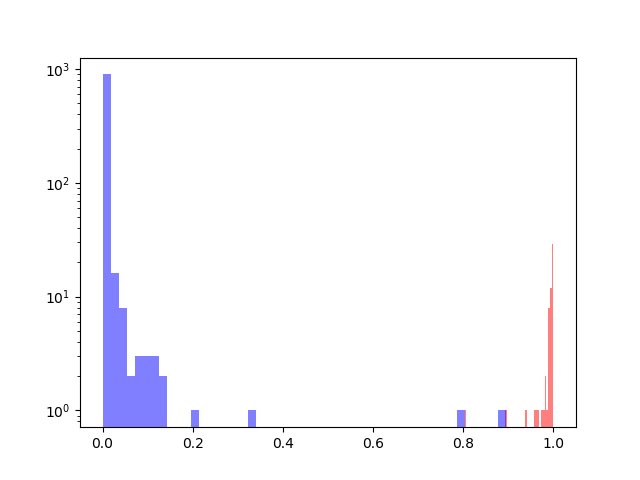

(array([899.,  16.,   8.,   2.,   3.,   3.,   3.,   2.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([2.57316879e-09, 1.78803255e-02, 3.57606483e-02, 5.36409712e-02,
        7.15212941e-02, 8.94016170e-02, 1.07281940e-01, 1.25162263e-01,
        1.43042586e-01, 1.60922909e-01, 1.78803231e-01, 1.96683554e-01,
        2.14563877e-01, 2.32444200e-01, 2.50324523e-01, 2.68204846e-01,
        2.86085169e-01, 3.03965492e-01, 3.21845814e-01, 3.39726137e-01,
        3.57606460e-01, 3.75486783e-01, 3.93367106e-01, 4.11247429e-01,
        4.29127752e-01, 4.47008075e-01, 4.64888397e-01, 4.82768720e-01,
        5.00649043e-01, 5.18529366e-01, 5.36409689e-01, 5.54290012e-01,
        5.72170335e-01, 5.90050658e-01, 6.07930981e-01, 6.25811303e-01,
        6.

In [110]:
sgp = p11[ y11 == 1]
sgn = p11[ y11 == 0]
ax1 = plt.subplot(1,1,1)
ax1.clear()
ax1.hist(sgp,bins=50,color='r',log=True,alpha=0.5)
ax1.hist(sgn,bins=50,color='b',log=True,alpha=0.5)

In [111]:
mis_took_positives = []
for ind in range(len(y11)):
    if y11[ind] == 1 and p11[ind] < 0.5:
        mis_took_positives.append(ind)

In [112]:
mis_took_negetives = []
for ind in range(len(y11)):
    if y11[ind] == 0 and p11[ind] > 0.5:
        mis_took_negetives.append(ind)

In [113]:
len(mis_took_positives),len(mis_took_negetives)

(0, 2)

In [114]:
mis_took_positives[:5], mis_took_negetives[:5]

([], [82, 953])

In [120]:
train.loc[80]['comment_text']

'I thought Willamette week was better than this. Using weasel  wording  and referring  to a vanity fair hit piece to spread a misinformed  view what furriers are. We all do not obsessed about and or dress up. Only 10% 15% furs   dress up in costume; you find a great ratio of costumers (cosplay) at Kumoricon and New Con than a fur con.  We fur have many different and dare say family  friendly  safe for work interest including art, role  play and  literature. In fact looking  at the Loyd center piece, the pictures could been take around January 2-3. We had a furry meet up  Loyd\'s Center and the "reporter" could had easily missed us.'

In [118]:
train.loc[82]['target']

0.4

In [62]:
# mis took pos hist plot
probs_mtp = train.loc[mis_took_positives]['target'].values
ax = plt.subplot(1,2,1)
ax.hist(probs_mtp,bins=10,log=True)
# mis took negs hist plot
probs_mtn = train.loc[mis_took_negetives]['target'].values
ax = plt.subplot(1,2,2)
ax.hist(probs_mtn,bins=10,log=True)

(array([6., 0., 0., 0., 0., 0., 0., 1., 0., 1.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ]),
 <a list of 10 Patch objects>)

In [88]:
train_dataset1[14][0]

tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [84]:
tokenizer.sequences_to_texts(([2,1550,549,7616],[1,2,3]))

['to quote yourself wtf', 'the to and']

In [50]:
# end

In [34]:
p = get_preds_test(model,test_dataset)

In [35]:
pred = p[:,0]

In [36]:
len(pred)

97320

In [37]:
ss = pd.read_csv('../../../data/sample_submission.csv')
ss.shape

(97320, 2)

In [37]:
ss.head(2)

,id,prediction
0,7000000,1.860598e-05
1,7000001,6.594191e-07


In [36]:
ss.prediction = pred

In [40]:
ss.to_csv('subb25.csv',index=False)

In [41]:
_ = pd.read_csv('subb25.csv')
_.head(2)

,id,prediction
0,7000000,1.860598e-05
1,7000001,6.594191e-07


In [38]:
from jigsaw_metric import *
#val = calc_roc(train,model,tokenizer,MAX_LEN)
#print(val)

In [24]:
df,met,pred_data = bias_metrics(train,model,tokenizer,MAX_LEN)
print(df)


                        subgroup    sg_auc   sg_bpsn   sg_bnsp
0                           male  0.988402  0.989041  0.992261
1                         female  0.987774  0.989629  0.991318
2      homosexual_gay_or_lesbian  0.974113  0.962342  0.994997
3                      christian  0.987457  0.990634  0.989647
4                         jewish  0.981430  0.983889  0.990890
5                         muslim  0.976852  0.973942  0.993631
6                          black  0.972629  0.964919  0.994341
7                          white  0.969943  0.970317  0.993085
8  psychiatric_or_mental_illness  0.988942  0.981902  0.995424


In [26]:
len(pred_data)

9

In [42]:
identity = 'christian'

_ = pred_data[identity]['sg'];
sgp = _[1][ _[0] == 1]
sgn = _[1][ _[0] == 0]
ax1 = plt.subplot(2,2,1)
ax1.clear()
ax1.hist(sgp,bins=50,color='r',log=True,alpha=0.5)
ax1.hist(sgn,bins=50,color='b',log=True,alpha=0.5)

ax2 = plt.subplot(2,2,2)
ax2.clear()
_ = pred_data[identity]['sg_bpsn'];
sgp = _[1][ _[0] == 1]
sgn = _[1][ _[0] == 0]
ax2.hist(sgp,bins=50,color='r',log=True,alpha=0.5)
ax2.hist(sgn,bins=50,color='b',log=True,alpha=0.5)

ax3 = plt.subplot(2,2,3)
ax3.clear()
_ = pred_data[identity]['sg_bnsp'];
sgp = _[1][ _[0] == 1]
sgn = _[1][ _[0] == 0]
ax3.hist(sgp,bins=50,color='r',log=True,alpha=0.5)
ax3.hist(sgn,bins=50,color='b',log=True,alpha=0.5)

NameError: name 'pred_data' is not defined

In [3]:
a = {'train':[]}

In [6]:
a['train']

[]

In [7]:
import numpy as np

In [10]:
a = np.random.rand(5,3);
a

array([[0.10978415, 0.77817642, 0.61862947],
       [0.20634747, 0.73065781, 0.15636014],
       [0.0608287 , 0.74404356, 0.87516245],
       [0.56539871, 0.53418826, 0.4440484 ],
       [0.38053059, 0.92986475, 0.67516221]])

In [11]:
np.split(a,[2,3])

[array([[0.10978415, 0.77817642, 0.61862947],
        [0.20634747, 0.73065781, 0.15636014]]),
 array([[0.0608287 , 0.74404356, 0.87516245]]),
 array([[0.56539871, 0.53418826, 0.4440484 ],
        [0.38053059, 0.92986475, 0.67516221]])]

In [12]:
np.sample()

AttributeError: module 'numpy' has no attribute 'sample'

In [121]:
df = pd.read_csv('../../../data/train.csv')

In [133]:
df.comment_text[10]

'Wow, that sounds great.'

In [134]:
df.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


In [135]:
df.article_id.nunique()

105380

In [136]:
df.article_id.unique()

array([  2006,  26662,  26650, ..., 399539, 399496, 399541])

In [137]:
df1 = df[df.article_id == 2006]

In [141]:
pd.options.display.max_columns = None
df1.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [145]:
df.parent_id.unique()

array([     nan,  239522.,  239519., ..., 6333871., 6333833., 6333965.])